# We have to import the necessary libraries and our dataset


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import pandas as pd

In [3]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header = None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Then we have to separate the **Normal Data** and **Abnormal Data** and then plot those datas

In [5]:
normal_ecg_df = df[df.iloc[:, 140] == 1][:]
abnormal_ecg_df = df[df.iloc[:, 140] == 0][:]

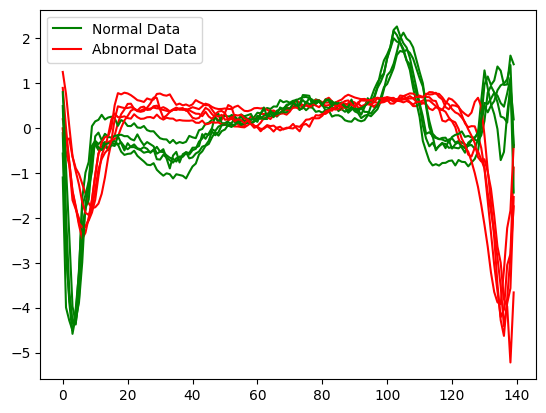

In [6]:
for i in range(5):
  plt.plot(normal_ecg_df.iloc[i,:140], 'g', label = 'Normal Data' if i == 0 else None)
  plt.plot(abnormal_ecg_df.iloc[i,:140], 'r', label = 'Abnormal Data' if i == 0 else None)

plt.legend()
plt.show()

Now we're going to build the **AnomalyDetector Model** by creating a class.
We are going to take in the input, **encode it to its latent form and then decode it similar to the original data.**

That's why we have a part called **self.encoder** and another part called **self.decoder.**

After building the class, we have to instantiate the model.
We also have to compile the model

In [7]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(140, activation = "relu"),
        layers.Dense(70, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(8, activation = "relu")])

    self.decoder = tf.keras.Sequential([
        layers.Dense(8, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(32, activation = "relu"),
        layers.Dense(16, activation = "relu"),
        layers.Dense(140, activation = "sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [8]:
AnomalyDetector = Autoencoder()

In [9]:
AnomalyDetector.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam())

Here we're converting the **DataFrame** to **Numpy Array**

In [10]:
normal_ecg_val = normal_ecg_df.to_numpy()
abnormal_ecg_val = abnormal_ecg_df.to_numpy()

We have to train using 80% of the normal, and leave out 20% of the normal and 100% of the abnormal to be tested

You don't need the y value of the data, you only needed it to separate the normal and the abnormal

In [11]:
split = int(len(normal_ecg_val) * 0.8)
training_data = normal_ecg_val[:split,:140]
testing_data = normal_ecg_val[split:,:140]

In [12]:
#Normalizing data to set it between 0 and 1

min_val = tf.reduce_min(training_data)
max_val = tf.reduce_max(training_data)

training_data = (training_data - min_val)/(max_val - min_val)
testing_data = (testing_data - min_val)/(max_val - min_val)

training_data = tf.cast(training_data, tf.float32)
testing_data = tf.cast(testing_data, tf.float32)

In [13]:
#All of the abnormal data are used for testing
#Normalizing data to set it between 0 and 1

abnormal_test_data = abnormal_ecg_val[:,:140]

min_val = tf.reduce_min(abnormal_test_data)
max_val = tf.reduce_max(abnormal_test_data)

abnormal_test_data = (abnormal_test_data - min_val)/(max_val - min_val)
abnormal_test_data = tf.cast(abnormal_test_data, tf.float32)

In [14]:
AnomalyDetector.build(input_shape = (None, 140))

We're going to train the model now.

I used epoch of 200. You can try and change the hyperparameters.

In [ ]:
AnomalyDetector.fit(training_data, training_data, batch_size = 64, epochs=200, validation_data=(testing_data,testing_data))

In [16]:
train = AnomalyDetector.predict(training_data)
recon = AnomalyDetector.predict(testing_data)
abnormal = AnomalyDetector.predict(abnormal_test_data)

65/65 [==============================] - 0s 2ms/step


As you can see in the plot below, the model can reconstruct the normal data very well

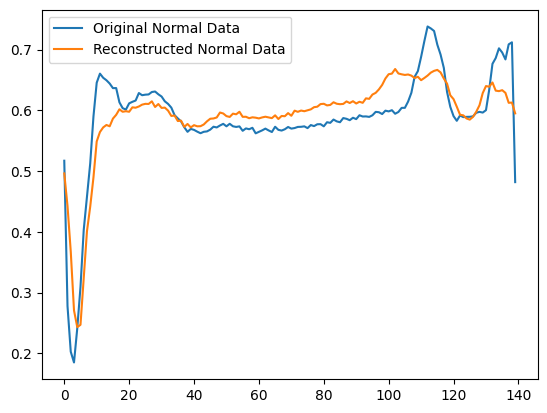

In [17]:
plt.plot(testing_data[194,:], label = 'Original Normal Data')
plt.plot(recon[194], label = 'Reconstructed Normal Data')
plt.legend()
plt.show()

But it's facing some issues when reconstructing abnormal data

[]

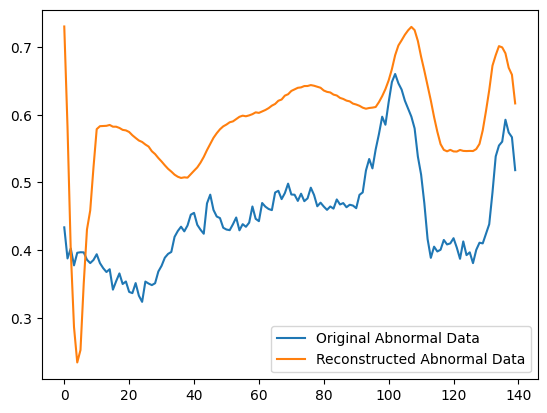

In [18]:
plt.plot(abnormal_test_data[291], label = 'Original Abnormal Data')
plt.plot(abnormal[291], label = 'Reconstructed Abnormal Data')
plt.legend()
plt.plot()

We can analyze the loss value and set a threshold to distinguish between **normal and abnormal ECG data**


In [19]:
mseloss = tf.keras.losses.MeanSquaredError()

In [20]:
train_normal_data_loss = []
normal_data_loss = []
abnormal_data_loss = []

In [21]:
for i in range(len(training_data)):
  loss = mseloss(training_data[i], train[i])
  train_normal_data_loss.append(loss)

In [22]:
for i in range(len(recon)):
  loss = mseloss(testing_data[i], recon[i])
  normal_data_loss.append(loss)

In [23]:
for i in range(len(abnormal)):
  loss = mseloss(abnormal_test_data[i], abnormal[i])
  abnormal_data_loss.append(loss)

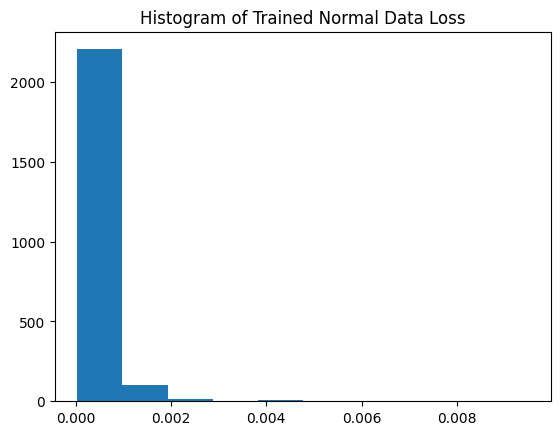

In [24]:
plt.hist(train_normal_data_loss)
plt.title('Histogram of Trained Normal Data Loss')
plt.show()

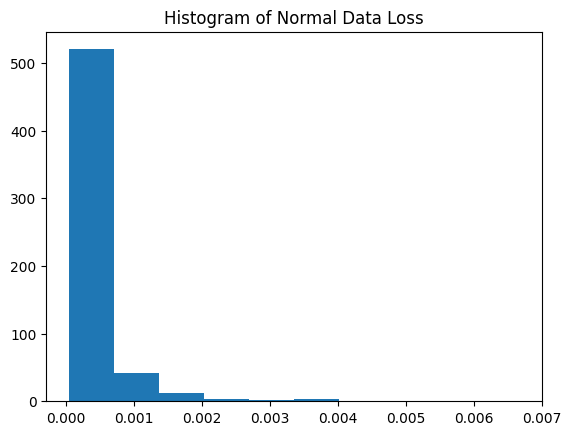

In [25]:
plt.hist(normal_data_loss)
plt.title('Histogram of Normal Data Loss')
plt.show()

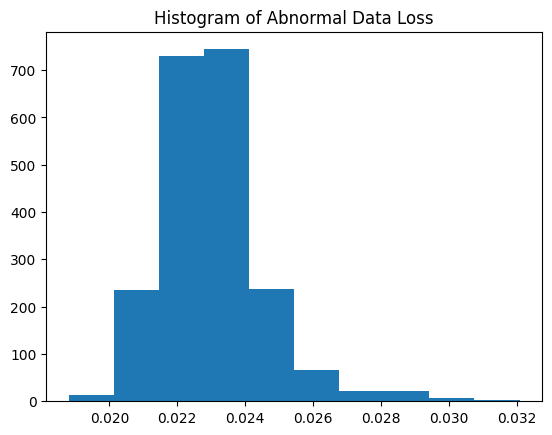

In [26]:
plt.hist(abnormal_data_loss)
plt.title('Histogram of Abnormal Data Loss')
plt.show()

Analyzing all three graphs, we can conclude that the **reconstructed abnormal data has loss over 0.015** and **reconstructed normal data has under 0.005**. So, we'll set our threshold at **0.01**

In [27]:
threshold = 0.01

We can see that the model works pretty well, you can use metrics function to find the accuracy of the model.